# SEAROSE ICE INCURSION INCIDENT

In [1]:
import netCDF4 as nc
import numpy as np
import xarray as xr

# CONSTANTS

In [2]:
from icedef.constants import *

# SEAROSE

In [3]:
searose_latitude = 46.78851
searose_longitude = -48.01405

# ICEBERG

In [4]:
from icedef.iceberg import quickstart, dx_to_dlon, dy_to_dlat

In [5]:
# At 0145 on March 29, 2017, berg 011 was 4.2 NM away from SeaRose at a bearing of 346 deg T
iceberg_time = np.datetime64('2017-03-29T01:45')
iceberg_latitude = 46.85639904
iceberg_longitude = -48.03872578
iceberg = quickstart(iceberg_time, (iceberg_latitude, iceberg_longitude))

In [6]:
start_time = iceberg_time
end_time = np.datetime64(iceberg_time + np.timedelta64(1, 'D'))
start_latitude = iceberg_latitude
start_longitude = iceberg_longitude

# METOCEAN

In [7]:
from icedef import metocean

In [8]:
ocean = metocean.ECMWFOcean((start_time, end_time))
atm = metocean.NARRAtmosphere((start_time, end_time))

Attempting to download ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20170329.nc... done.


# DRIFT

In [9]:
from icedef import drift

In [10]:
tdelta = np.timedelta64(360, 's')
dt = tdelta / np.timedelta64(1, 's')
nt = int((end_time - start_time) / tdelta)

In [11]:
iceberg = quickstart(start_time, (start_latitude, start_longitude))

iceberg_constants = {
    'sail_area': iceberg.geometry.sail_area,
    'keel_area': iceberg.geometry.keel_area,
    'top_area': iceberg.geometry.waterline_length**2,
    'bottom_area': 0,
    'mass': iceberg.geometry.mass,
    'latitude': iceberg.latitude
}

point = (iceberg.time, iceberg.latitude, iceberg.longitude)

current_velocity = (metocean.interpolate(point, ocean.eastward_current_velocities),
                    metocean.interpolate(point, ocean.northward_current_velocities))

wind_velocity = (metocean.interpolate(point, atm.eastward_wind_velocities),
                 metocean.interpolate(point, atm.northward_wind_velocities))

curr_vel_history = []
wind_vel_history = []

for t in range(nt):
    
    ax, ay = drift.newtonian_drift((iceberg.eastward_velocity, iceberg.northward_velocity), 
                             current_velocity, wind_velocity, 
                             iceberg_constants)
    
    iceberg.time += tdelta
    iceberg.eastward_velocity += ax * dt
    iceberg.northward_velocity += ay * dt
    iceberg.latitude += dy_to_dlat(iceberg.northward_velocity * dt)
    iceberg.longitude += dx_to_dlon(iceberg.eastward_velocity * dt, iceberg.latitude)
    
    point = (iceberg.time, iceberg.latitude, iceberg.longitude)
    
    curr_vel_history.append(current_velocity)
    wind_vel_history.append(wind_velocity)
    
    current_velocity = (metocean.interpolate(point, ocean.eastward_current_velocities),
                        metocean.interpolate(point, ocean.northward_current_velocities))

    wind_velocity = (metocean.interpolate(point, atm.eastward_wind_velocities),
                     metocean.interpolate(point, atm.northward_wind_velocities))
    
    iceberg_constants['latitude'] = iceberg.latitude
    iceberg.update_history()

# PLOT

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

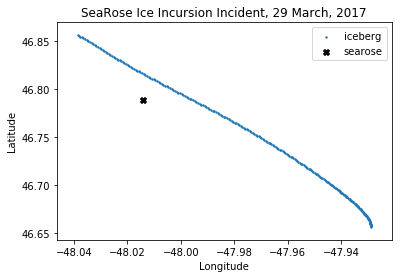

In [13]:
plt.scatter(iceberg.history['longitude'], iceberg.history['latitude'], 
            s=2, label='iceberg')
plt.scatter(searose_longitude, searose_latitude, marker='X', c='black', label='searose')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('SeaRose Ice Incursion Incident, 29 March, 2017')
plt.show()

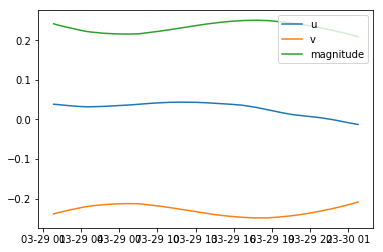

In [32]:
curr_u_vel_history = [u for u, v in curr_vel_history]
curr_v_vel_history = [v for u, v in curr_vel_history]
curr_vel_mag_history = [np.sqrt(u**2 + v**2) for u, v in curr_vel_history]
plt.plot(iceberg.history['time'], curr_u_vel_history, label='u')
plt.plot(iceberg.history['time'], curr_v_vel_history, label='v')
plt.plot(iceberg.history['time'], curr_vel_mag_history, label='magnitude')
plt.legend()
plt.show()
plt.close()

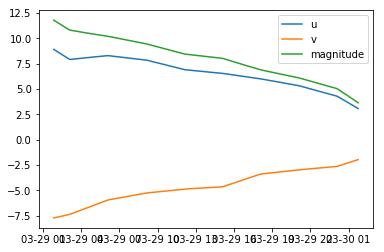

In [33]:
wind_u_vel_history = [u for u, v in wind_vel_history]
wind_v_vel_history = [v for u, v in wind_vel_history]
wind_vel_mag_history = [np.sqrt(u**2 + v**2) for u, v in wind_vel_history]
plt.plot(iceberg.history['time'], wind_u_vel_history, label='u')
plt.plot(iceberg.history['time'], wind_v_vel_history, label='v')
plt.plot(iceberg.history['time'], wind_vel_mag_history, label='magnitude')
plt.legend()
plt.show()
plt.close()

### Why do some of the interpolated values of current velocity go to zero?

#### Solved. There was an error downloading ocean data file 20170329.nc due to a slow internet connection. Therefore, the metocean class was reading in an file from cache that was incompletely downloaded."

In [82]:
lat_bounds = (46.65, 46.75)
lon_bounds = (-47.96, -47.92)
time_indx_bounds = np.where(abs(np.asarray(curr_vel_mag_history)) < 1e-6)[0][0], np.where(abs(np.asarray(curr_vel_mag_history)) < 1e-6)[0][-1]
time_indx_bounds = np.where(ocean.dataset.time < iceberg.history['time'][time_indx_bounds[0]])[0][-1], np.where(ocean.dataset.time > iceberg.history['time'][time_indx_bounds[1]])[0][-1]
lat_indx_bounds = np.where(ocean.dataset.latitude < lat_bounds[0])[0][-1], np.where(ocean.dataset.latitude > lat_bounds[1])[0][0]
lon_indx_bounds = np.where(ocean.dataset.longitude < lon_bounds[0])[0][-1], np.where(ocean.dataset.longitude > lon_bounds[1])[0][0]
time_indx_bounds, lat_indx_bounds, lon_indx_bounds

((23, 47), (79, 82), (144, 145))

In [81]:
iceberg.history['time'][time_indx_bounds[1]]

numpy.datetime64('2017-03-29T04:15:00')

In [77]:
np.where(ocean.dataset.time > iceberg.history['time'][time_indx_bounds[1]])

(array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
        41, 42, 43, 44, 45, 46, 47]),)

In [83]:
eastward_current_velocity_subset = ocean.eastward_current_velocities[time_indx_bounds[0]: time_indx_bounds[1] + 1,
                                                                      lat_indx_bounds[0]: lat_indx_bounds[1] + 1,
                                                                      lon_indx_bounds[0]: lon_indx_bounds[1] + 1]

In [84]:
eastward_current_velocity_subset

<xarray.DataArray (time: 25, latitude: 4, longitude: 2)>
array([[[ 0.      ,  0.      ],
        [ 0.      ,  0.      ],
        [ 0.      ,  0.      ],
        [ 0.      ,  0.      ]],

       [[-0.022584, -0.026246],
        [-0.001831, -0.005493],
        [ 0.012818,  0.007324],
        [ 0.025025,  0.020142]],

       [[-0.027467, -0.031129],
        [-0.006104, -0.010376],
        [ 0.008545,  0.003662],
        [ 0.020753,  0.01587 ]],

       [[-0.030519, -0.034181],
        [-0.009156, -0.012818],
        [ 0.006104,  0.001831],
        [ 0.018921,  0.014039]],

       [[-0.031739, -0.035401],
        [-0.009766, -0.014039],
        [ 0.005493,  0.001831],
        [ 0.018311,  0.014039]],

       [[-0.031129, -0.035401],
        [-0.009766, -0.014039],
        [ 0.005493,  0.001831],
        [ 0.018311,  0.015259]],

       [[-0.028077, -0.03296 ],
        [-0.007324, -0.012207],
        [ 0.007324,  0.003662],
        [ 0.018921,  0.01709 ]],

       [[-0.023804, -0.029298],
 

In [85]:
ocean.dataset.time

<xarray.DataArray 'time' (time: 48)>
array(['2017-03-29T00:30:00.000000000', '2017-03-29T01:30:00.000000000',
       '2017-03-29T02:30:00.000000000', '2017-03-29T03:30:00.000000000',
       '2017-03-29T04:30:00.000000000', '2017-03-29T05:30:00.000000000',
       '2017-03-29T06:30:00.000000000', '2017-03-29T07:30:00.000000000',
       '2017-03-29T08:30:00.000000000', '2017-03-29T09:30:00.000000000',
       '2017-03-29T10:30:00.000000000', '2017-03-29T11:30:00.000000000',
       '2017-03-29T12:30:00.000000000', '2017-03-29T13:30:00.000000000',
       '2017-03-29T14:30:00.000000000', '2017-03-29T15:30:00.000000000',
       '2017-03-29T16:30:00.000000000', '1950-01-01T00:00:00.000000000',
       '1950-01-01T00:00:00.000000000', '1950-01-01T00:00:00.000000000',
       '1950-01-01T00:00:00.000000000', '1950-01-01T00:00:00.000000000',
       '1950-01-01T00:00:00.000000000', '1950-01-01T00:00:00.000000000',
       '2017-03-30T00:30:00.000000000', '2017-03-30T01:30:00.000000000',
       '2017-0